## Projeto 2.2 Detector e contador de pessoas em imagens

#### Engenharia da Computação - Insper
#### Visão Computacional Avançada 2018.2
Isabella Rocha de Oliveira

Este projeto tem como objetivo utilizar os conhecimentos de visão computacional vistos em sala de aula para detectar e contar a quantidade de pessoas passando em um local monitorado por câmeras fixas, seguindo o método apresentado pelo artigo “Real-time foreground-background segmentation using codebook model”. 

In [54]:
%reset -f
%matplotlib inline

#!pip install opencv-python

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
import random

print(cv.__version__)

3.4.2


O método sugere que seja utilizado um sistema de codebook para salvar informações relevantes de cada pixel de imagens do background em questão (um ambiente sem pessoas ou objetos móveis), com diversas imagens deste mesmo ambiente, para realizar um treinamento do algoritmo. 
Desta forma esperasse que o algoritmo entenda o que é o background e o que distoar disso em outras imagens seria o foreground.


Cada pixel possui seu codebook e cada codebook possui uma quantidade variável de codewords. Nos codewords são salvos dados como os valores R, G e B do mesmo, valores sobre intensidade e também variáveis temporais.

In [55]:
class Codebook(): #cada pixel tem um
    def __init__(self, L, rows, cols):
        self.L = L #quantidade de codewords
        self.rows = rows
        self.cols = cols
        
class Codeword(): #vários formam um codebook, qtd varia
    def ___init__(self, vetorRGB, vetorAux):
        self.v = vetorRGB
        self.aux = vetorAux #6 tuple

Cada codebook vai armazenar diferentes codewords sobre um mesmo pixel e cada um desses codewords será originado de uma ou mais imagens diferentes, por isso, para gerar um codebook é necessário passar mais de uma imagem no treinamento.

In [56]:
bg = cv.imread('./Crowd_PETS09/S0/Background/View_001/Time_13-06/00000001.jpg', 0)
rows, cols = bg.shape

imagens = []
i = 0
n = 10
while i < n:
    number = random.randint(1, 446)
    imagens.append(number)
    i += 1
    
#imagens a serem utilizadas
print(imagens)

[349, 2, 411, 375, 197, 274, 77, 85, 251, 253]


255


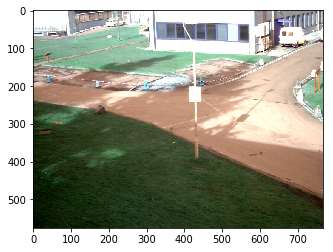

In [57]:
bg = []
count = 0
for k in imagens:
    bg.append(cv.imread('./Crowd_PETS09/S0/Background/View_001/Time_13-06/{:08d}.jpg'.format(k)))
    #plt.imshow(bg[count])
    count = count + 1
    
plt.imshow(bg[5])
print(bg[5][0, 0, 0]) #pra pegar o RGB

Para a construção dos codebooks, foi gerado inicialmente uma lista de codebooks e nela há um codebook vazio para cada pixel das imagens que serão treinadas. Cada imagem será passada pelo tratamento e cada pixel dela será verificado na intenção de criar novos codewords para o codebook daquele pixel ou atualizar um codeword existente em determinados codebooks. Caso o codebook do pixel tratado em questão não possuia nenhum codeword ou não possua nenhum codeword que atenda as condições de brightness e colordist especificadas, é criado um novo codeword. Caso haja um codeword naquele codebook que dê match em ambas as condições para o pixel tratado no momento, este codeword é atualizado e idealmente seria deslocado como o primeiro codeword do codebook, para agilizar o processo de treinamento, porém neste projeto isso não será realizado. 

As funções colordist e brightness foram criadas para facilitar no momento de checagem se um codeword existente deveria ser atualizado (pois houve a ocorrência de match com o pixel atual) ou se deveria ser adicionado ao codebook (quando não ocorre match).
A função colordist calcula a distorção de cores entre o RGB do pixel atual e o RGB do codeword existente daquele pixel. Já a função brightness verifica se a luminosidade do pixel atual está no intervalo entre os valores de luminosidade baixa e alta.

In [58]:
#condições para alterar

def colordist(xt, vi):
    modxt2 = (xt[0]**2 + xt[1]**2 + xt[3]**2)
    modvi2 = (vi[0]**2 + vi[1]**2 + vi[3]**2)
    modxtvi2 = ((xt[0]*vi[0]) + (xt[1]*vi[1]) + (xt[3]*vi[3]))**2
    distortion = math.sqrt(modxt2 - (modxtvi2/modvi2)) 
    
    return distortion


def brightness(xt, Imin, Imax):
    alpha = (0.4 + 0.7)/2
    beta = (1.1 + 1.5)/2
    Ilow = alpha * Imax
    Ihi = min(beta * Imax, (Imin/alpha))
    modxt = math.sqrt(xt[0]**2 + xt[1]**2 + xt[3]**2)
    
    if (Ilow <= modxt) and (Ihi >= modxt): #true pros 2
        return True
    
    else: 
        return False
    

In [63]:
N = 10 #número de treinamentos em cada pixel
L = 0 #quantidade de codewords em cada codebook
X = [] #lista com os diferentes vetorRGB de um pixel nas diferentes rodadas, vai até N
C = [] #codebook para cada pixel, vai até L, não pode ser matriz
E1 = 10 #não sei que valor colocar :(
for i in range(rows):
    C.append([])
    for j in range(cols):
        C[i].append([])

#fazer isso para cada imagem
for t in range(1, N+1):
    for i in range(rows):
        for j in range(cols):
            R = bg[t-1][i, j, 0]
            G = bg[t-1][i, j, 1]
            B = bg[t-1][i, j, 2]
            xt = (R, G, B)
            I = math.sqrt(R**2 + G**2 + B**2)
#Até aqui pegou RGB de todo mundo da imagem. Precisa por no codebook
#Pra por no codebook não pode dar match em nenhum
#Pra atualizar codebook tem que satisfazer condição a e b

            for k in C[i][j]:
                if((colordist(xt, k.v) <= E1) and (brightness(xt, k.aux[0], k.aux[1]) == True)): #criar funcoes colordist e brightness urgentemente
                    match = True #para não correr riscos de entrar na adiciona
                    #atualiza
                    fm = k.aux[2] #frequencia codew
                    Rm = (fm* k.v[0] + R)/(fm+1)
                    Gm = (fm* k.v[1] + G)/(fm+1)
                    Bm = (fm* k.v[2] + B)/(fm+1)
                    Vm = (Rm, Gm, Bm)
                    auxm = [min(I, k.aux[0]), max(I, k.aux[1]), fm+1, max(k.aux[3], t-k.aux[5]), k.aux[4], t]
                    
                elif((L == 0) or (match == False)):
                    #adiciona
                    vetorAux = (I, I, 1, t-1, t, t)
                    code = Codeword(xt, vetorAux)
                    L = L+1
                    C[rows][cols].append(code)
                match = False

    #setando o lambda
    for i in range(rows):
        for j in range(cols):
            for k in C[i][j]:
                    k.aux[3] = max(k.aux[3], (N-k.aux[5]+k.aux[4]-1))    

Um codeword apenas será  atualizado se a distorção calculada pela função colordist for menor ou igual o coeficiente E1 e, ao mesmo tempo, a função brightness retornar True, indicando que a luminosidade do pixel está entre o intervalo especificado. Caso contrário, um novo codeword é criado.

Para finalizar é necessário atualizar o lambda de todos os codewords de todos os pixels da imagem.